In [1]:
import pandas as pd
import os
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder  
from matplotlib.text import Annotation
import numpy as np
import plotly.express as px

from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.graph_objects as go
import pickle

import chart_studio.plotly as py
import plotly as py2
from chart_studio.plotly import iplot

from plotly.offline import plot

# Importing the data

In [2]:
path = '../data/dunnhumby - The Complete Journey CSV'
transaction_df = pd.read_csv(os.path.join(path,"transaction_data.csv"))
product_df = pd.read_csv(os.path.join(path,"product.csv"))
hh_demographic_df = pd.read_csv(os.path.join(path,"hh_demographic.csv"))
#Note the bag of commodities was obtained using spark in a Google colab Notebook
bag_of_commodities = pd.read_csv('../data/results/sub_commodity_bag.csv')

In [3]:
bag_of_commodities.set_index(["household_key"], inplace=True)

# Exploratory 

In [4]:
#Select the most bought products
trans_df = transaction_df.merge(product_df, on="PRODUCT_ID", how='inner')
top_sales_products = trans_df.groupby('SUB_COMMODITY_DESC')['SALES_VALUE'].sum(). \
                        sort_values(ascending=False).head(30)


In [5]:
fig = go.Figure()
fig.add_trace(go.Bar(y = top_sales_products.values, orientation='v'))
fig.update_xaxes(ticktext=top_sales_products.index,
                    tickvals=list(range(top_sales_products.size)))
#We see that gasoline makes the most sales by far

# Kmeans clustering

In [6]:
#The bag of commodities was obtained by couting the number of times each household has bought each item 
#This is analgous to the bag of words technique, this matrix is very sparse and high dimensional
#This is why we will perform SVD on it to obtain the representations in group space
# initialize transformer, to give less weight to frequently bought items
transformer = TfidfTransformer()
normalized_bag_of_commodities = transformer.fit_transform(bag_of_commodities.fillna(0).values)

#Select 300 potential groups to keep
svd = TruncatedSVD(300)
# Max-normalize for k-means
normalizer = Normalizer(copy=False)
#households vs group matrix
households_groups = svd.fit_transform(normalized_bag_of_commodities)
households_groups = normalizer.fit_transform(households_groups)
#groups vs items matrix
groups_items = svd.components_


## Explained Variance of Groups

In [7]:
#By looking at the explained variance ratio we can assess how representative the groups are. 

print("Sum of explained variance: ", np.around(svd.explained_variance_ratio_.sum(),3), "%")

print("Proportion of variance expalained by the first 10 components ", 
          np.around(svd.explained_variance_ratio_[0:10].sum(),3), "%")

#We see that a large amount of the variance in the data is explained by the first 300 groups, 
#and the first 10 groups correspond to approximately to half. 
#Thus we can focus on the top 10 groups for clustering. 

#We will try to find if there are any patterns in the groups obtained from the decomposition. 

Sum of explained variance:  0.781 %
Proportion of variance expalained by the first 10 components  0.271 %


In [8]:
groups_df = pd.DataFrame(groups_items,columns=bag_of_commodities.columns)
groups_df.apply(lambda x: pd.Series(np.concatenate([x.nlargest(10).index.values])), axis=1).head(8)

0                               1  \
0           GASOLINE-REG UNLEADED             BEERALEMALT LIQUORS   
1  SOFT DRINKS 12/18&15PK CAN CAR             BEERALEMALT LIQUORS   
2             BEERALEMALT LIQUORS                      CIGARETTES   
3                      CIGARETTES                    BABY DIAPERS   
4                    BABY DIAPERS        INFANT FORMULA MILK BASE   
5  FRZN SS PREMIUM ENTREES/DNRS/N                      CIGARETTES   
6  SOFT DRINKS 12/18&15PK CAN CAR  SOFT DRINKS 20PK&24PK CAN CARB   
7        INFANT FORMULA MILK BASE        INFANT FORMULA SPECIALTY   

                                2                         3  \
0  SOFT DRINKS 12/18&15PK CAN CAR     FLUID MILK WHITE ONLY   
1           FLUID MILK WHITE ONLY                CIGARETTES   
2             AUSTRALIAN/NZ WINES          VALUE GLASS WINE   
3          PREPAID WIRELESS CARDS  INFANT FORMULA MILK BASE   
4             BEERALEMALT LIQUORS  INFANT FORMULA SPECIALTY   
5          YOGURT NOT MULTI-PACKS              ADULT CEREAL   
6  FRZN SS PREMIUM ENTREES/DNRS/N  INFANT FORMULA MILK BASE   
7            BABY FOOD - BEGINNER    INFANT FORMULA TODDLER   

                      4                               5  \
0            CIGARETTES                     CHOICE BEEF   
1           CHOICE BEEF                    BABY DIAPERS   
2   PREMIUM 750ML WINES         FIGHTING VARIETAL WINES   
3                  LEAN  SOFT DRINKS 12/18&15PK CAN CAR   
4  BABY FOOD - BEGINNER         INFANT FORMULA SOY BASE   
5         PREMIUM BREAD  FRZN SS PREMIUM ENTREES/DNRS/T   
6   BEERALEMALT LIQUORS         SNACK CAKE - MULTI PACK   
7           SELECT BEEF   SEAFOOD-FRZ-IQF RAW SHRIMP RW   

                                6                             7  \
0                    BABY DIAPERS                        PRIMAL   
1                          PRIMAL                          LEAN   
2                       BOX WINES           POPULAR 750ML WINES   
3  SOFT DRINKS 20PK&24PK CAN CARB      INFANT FORMULA SPECIALTY   
4     BABY FOOD JUNIOR ALL BRANDS                    BABY WIPES   
5             PREMIUM 750ML WINES                       PREMIUM   
6               RAZORS AND BLADES  ISOTONIC DRINKS SINGLE SERVE   
7                     CHOICE BEEF   BABY FOOD JUNIOR ALL BRANDS   

                                8                               9  
0                 SHREDDED CHEESE                         PREMIUM  
1               SNACKS/APPETIZERS     FRZN BREADED PREPARED CHICK  
2                 SPARKLING WINES  LIQUEURS/SPECIALTIES (42 UNDER  
3         INFANT FORMULA SOY BASE           GASOLINE-REG UNLEADED  
4          INFANT FORMULA TODDLER     FEEDING ACCESSORIES BOTTLES  
5   RTS SOUP: CHUNKY/HOMESTYLE ET  DAIRY CASE 100% PURE JUICE - O  
6  SFT DRNK MLT-PK BTL CARB (EXCP  SFT DRNK SNGL SRV BTL CARB (EX  
7             PREMIUM 750ML WINES                          PRIMAL

In [9]:
groups_df.apply(lambda x: pd.Series(np.concatenate([x.nlargest(10), x.nsmallest(10)])), axis=1)\
                  .head(10)
#We look for groups were the variance is not only explained mostly by a single item, but rather by a group 
# of meaningfully related items
#For instance, group 2 seems to be fully caracterized by cigarettes and wine consumption

0         1         2         3         4         5         6  \
0  0.825062  0.161037  0.156610  0.146597  0.103511  0.090123  0.086675   
1  0.241677  0.237594  0.204017  0.197147  0.143187  0.136702  0.112787   
2  0.753551  0.472372  0.044084  0.039981  0.035726  0.031752  0.030319   
3  0.804657  0.158945  0.098018  0.093096  0.053434  0.051691  0.046892   
4  0.793335  0.364713  0.245342  0.164124  0.105670  0.092974  0.089505   
5  0.390958  0.190897  0.153923  0.113627  0.095775  0.095387  0.093320   
6  0.766939  0.210009  0.082200  0.051102  0.044473  0.040814  0.036513   
7  0.821621  0.294298  0.070159  0.051251  0.043858  0.028568  0.025846   
8  0.321656  0.308422  0.282209  0.157692  0.143582  0.115913  0.097744   
9  0.525301  0.465134  0.417578  0.227824  0.166551  0.105606  0.082179   

          7         8         9            10        11        12        13  \
0  0.074196  0.070011  0.063775 -2.431416e-24  0.000000  0.000000  0.000000   
1  0.112359  0.107379  0.103324 -5.598191e-01 -0.000935 -0.000582 -0.000536   
2  0.029321  0.027651  0.025548 -2.121788e-01 -0.128769 -0.118096 -0.079043   
3  0.041050  0.040251  0.039422 -4.362271e-01 -0.100987 -0.056673 -0.052372   
4  0.088300  0.061199  0.059766 -1.377379e-01 -0.093711 -0.069562 -0.061743   
5  0.087761  0.087629  0.086350 -2.384492e-01 -0.202038 -0.189491 -0.172872   
6  0.034557  0.032325  0.030080 -2.283884e-01 -0.221219 -0.165061 -0.118060   
7  0.024739  0.024232  0.021863 -4.270819e-01 -0.083259 -0.070338 -0.039363   
8  0.091681  0.089821  0.077174 -2.604063e-01 -0.222802 -0.221989 -0.178884   
9  0.059908  0.058155  0.057223 -2.975825e-01 -0.167592 -0.080571 -0.070435   

         14        15        16        17            18        19  
0  0.000000  0.000000  0.000000  0.000000  4.049996e-23  0.000002  
1 -0.000526 -0.000507 -0.000496 -0.000464 -4.342610e-04 -0.000419  
2 -0.076316 -0.068279 -0.064627 -0.063448 -6.221052e-02 -0.061553  
3 -0.051629 -0.050546 -0.046671 -0.043979 -3.649946e-02 -0.036238  
4 -0.050650 -0.050012 -0.049913 -0.047043 -3.929637e-02 -0.038652  
5 -0.152522 -0.137881 -0.097390 -0.095629 -9.348015e-02 -0.091855  
6 -0.117398 -0.114865 -0.104795 -0.092795 -7.850100e-02 -0.070577  
7 -0.031719 -0.029533 -0.023321 -0.022137 -2.099069e-02 -0.020644  
8 -0.172342 -0.169976 -0.138734 -0.136096 -1.262892e-01 -0.107675  
9 -0.065893 -0.061816 -0.056314 -0.055078 -5.406904e-02 -0.045259

In [10]:
#Select only interesting groups, where items bought together make sense
#chosen groups are 
item_names = ['Gasoline','Cigarettes and liquors','Baby items', 'Premium items', 'Soft drinks']
households_groups_filtered = households_groups[:,[0,2,4,5,6]]

#make a df with the coefficients of appartenance to the various groups
reduced_df = pd.DataFrame(households_groups_filtered,columns=item_names)
reduced_df.head()

Gasoline  Cigarettes and liquors  Baby items  Premium items  Soft drinks
0  0.307310               -0.084515   -0.091854      -0.083185    -0.117009
1  0.397550               -0.153161   -0.146531       0.096768     0.120952
2  0.359011               -0.167618    0.038279      -0.129833    -0.226612
3  0.592243               -0.092834    0.176409       0.093179     0.147600
4  0.824448                0.061689   -0.046818       0.014960    -0.057520

In [11]:
# Function computes the silhouette score at a given number of clusters and plots it
def find_optimal_kmeans(arr):
    #set n_init to 10 to get more robust results
    km = KMeans(init='k-means++',max_iter=100,n_init=20)
    s_score = []
    for n in range(2,15):
        km.set_params(n_clusters=n)
        km.fit(arr)
        s_score.append(metrics.silhouette_score(arr,km.labels_,sample_size=2500))
    plt.plot(range(2,15),s_score)
    plt.xlabel('n_clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.xticks(range(2,15))
    plt.show()

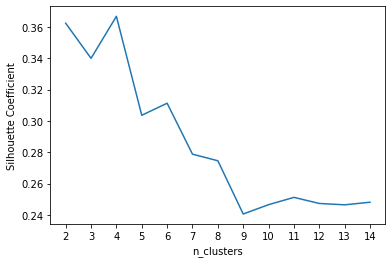

In [12]:
#the analysis of the silhouette coefficient for different possible group sizes tell us to choose 3 groups
#However, as the coefficient is also pretty high for 6 groups, we will choose 6
find_optimal_kmeans(households_groups_filtered)

In [1]:
## Visualize Clusters
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10)
km.fit(households_groups_filtered)

y_kmeans = km.predict(households_groups_filtered)


colors1 = ['r', 'b', 'g', 'y']
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(households_groups_filtered[:,0],households_groups_filtered[:,1],households_groups_filtered[:,2],c=y_kmeans, cmap=colors.ListedColormap(colors1))
ax.set_xlabel('Gasoline')
ax.set_ylabel('Cigarettes and Liquors')
ax.set_zlabel('Baby items')
plt.savefig("clusters.png")
plt.show()
#based on the 3d plot with the 3 most important groups on the axes, we already clear separations between groups

NameError: name 'KMeans' is not defined

In [14]:
#Interactive version
fig = go.Figure(data=[go.Scatter3d(x=households_groups_filtered[:,0], 
            y=households_groups_filtered[:,1], 
            z=households_groups_filtered[:,2],
            mode='markers',
            marker=dict(
            size=4,
            color=y_kmeans,   # set color to an array/list of desired values
            colorscale='portland',   # choose a colorscale
            opacity=0.8,
            showscale=True
            ))])
fig.show()
plot(fig, filename='kmeans_clusters.html')

'kmeans_clusters.html'

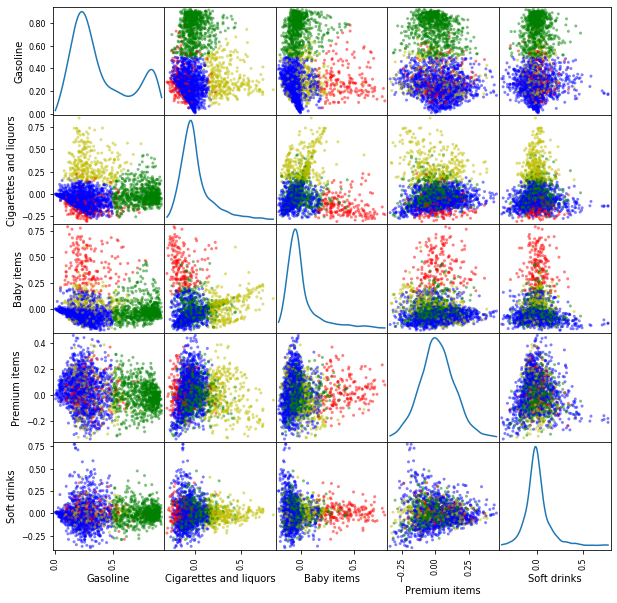

In [15]:
axes = pd.plotting.scatter_matrix(reduced_df, figsize=(10, 10),c=y_kmeans, cmap=colors.ListedColormap(colors1), diagonal= 'kde')
new_labels=["{0:.2f}".format(float(i.get_text())) for i in axes[0,0].get_yticklabels()]
axes[0,0].set_yticklabels(new_labels)

plt.savefig("scatter_matrix_kmeans_labels")
plt.show()

We see that even though some clusters overlap we see that clusters are representative:


*   0: Green: Drivers: gasoline consumption clearly higher than all other groups, But there is significant separation with the late night snacks group, which indicates that people who come to buy gasoline often also get food. Some overlapp with cigs & liquors and baby items.  
*   1: Blue: Smokers adn drinkers: Also buy gasoline but barely anything else, also some overlap with soft drinks and baby items
*   2: Yellow: Parents: medium snacks and high gasoline
*   3: Red: Passive consumers: also consume snacks, medium consumption of cigarettes and liquor!

From the distributions we see that the gasoline group is strongly skewed to the right and approximately follows a heavy tailed distribution and all the values are positive, which means that all the households consume from this group. Liquor and cigarettes and Late night snacks have similar distributions skewed to the left, meaning that most people do not buy from these groups. 

In [16]:
group_names = ['Drivers','Smokers and drinkers','Parents', 'Passive consumers']

## Cleaning of demographic df -> TO REMOVE AFTER

In [17]:
# Cast and set order
hh_demographic_df['INCOME_DESC'] = hh_demographic_df['INCOME_DESC'].astype('category')
hh_demographic_df.INCOME_DESC = hh_demographic_df.INCOME_DESC.cat.\
                                reorder_categories(['Under 15K', '15-24K','25-34K', '35-49K', '50-74K','75-99K', '100-124K','125-149K','150-174K', '175-199K', '200-249K', '250K+'], ordered=True)
# Cast and set order
hh_demographic_df.KID_CATEGORY_DESC = hh_demographic_df.KID_CATEGORY_DESC.astype('category')
hh_demographic_df.KID_CATEGORY_DESC.cat.reorder_categories(['1', '2', '3+', 'None/Unknown']\
                                                          , ordered=True, inplace=True)
# Casting
hh_demographic_df.HOMEOWNER_DESC = hh_demographic_df.HOMEOWNER_DESC.astype('category')
# Casting
hh_demographic_df.HH_COMP_DESC = hh_demographic_df.HH_COMP_DESC.astype('category')
# Cast and set order
hh_demographic_df.AGE_DESC = hh_demographic_df.AGE_DESC.astype('category')
hh_demographic_df.AGE_DESC.cat\
                    .reorder_categories(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True, inplace=True)
# Cast and set order
hh_demographic_df.HOUSEHOLD_SIZE_DESC = hh_demographic_df.HOUSEHOLD_SIZE_DESC.astype('category')
hh_demographic_df.HOUSEHOLD_SIZE_DESC.cat.reorder_categories(\
                        ['1', '2', '3', '4', '5+'], ordered=True, inplace=True)
# Cast
hh_demographic_df.MARITAL_STATUS_CODE = hh_demographic_df.MARITAL_STATUS_CODE.astype('category')
# Lowercase all column names
hh_demographic_df.columns = map(str.lower, hh_demographic_df.columns)

hh_demographic_df.set_index(hh_demographic_df["household_key"].astype('int64'), inplace=True)
hh_demographic_df = hh_demographic_df.drop(columns=["household_key"])

## Analysis of k-means groups demograpic data

In [18]:
#calculate the overall distributions for demographic parameters age , hh size and income
normal_age_desc = hh_demographic_df.groupby("age_desc")['income_desc'].count()
normal_income_desc = hh_demographic_df.groupby("income_desc")['income_desc'].count()
normal_household_size_desc = hh_demographic_df.groupby("household_size_desc")['income_desc'].count()

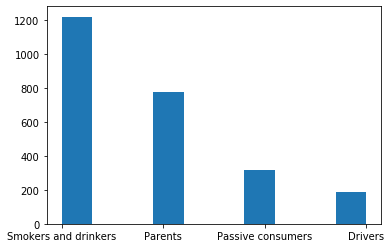

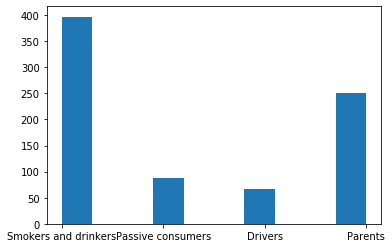

In [19]:
group_appartenance = [group_names[y_kmeans[i]] for i in range(len(y_kmeans))]
plt.hist(group_appartenance)
plt.show()


group_appartenance_df = pd.DataFrame(data= y_kmeans, index = reduced_df.index, columns=["group_nb"])
group_appartenance_df["group_name"] = group_appartenance
whole_df = group_appartenance_df.join(hh_demographic_df, how='inner')
#whole_df["group_name"] = group_appartenance

plt.hist(whole_df["group_name"])
plt.show()

In [20]:
#We count the number of hh in each categories for out defined groups
age_info = whole_df.groupby(["group_name"]).age_desc.value_counts()
income_info = whole_df.groupby(["group_name"]).income_desc.value_counts()
family_size_info = whole_df.groupby(["group_name"]).household_size_desc.value_counts()


#the we sort the categorical values and transform the data into 3 dataframes
family_size_info = family_size_info.sort_index()
age_info = age_info.sort_index()

res= []
income_order_list = ['Under 15K', '15-24K','25-34K', '35-49K', '50-74K','75-99K', '100-124K','125-149K','150-174K', '175-199K', '200-249K', '250K+']
for i in group_names:
    res.append(income_info[i].reindex(income_order_list))
    

income_info_df = pd.DataFrame(columns=income_order_list, \
                              data= np.divide(res, normal_income_desc.values), \
                              index = group_names)
income_info_df.fillna(0,inplace=True)
income_info_df.head()
#The dataframes contain the normalised proportion of households in each category

Under 15K    15-24K    25-34K    35-49K    50-74K  \
Drivers                0.065574  0.081081  0.116883  0.075581  0.109375   
Smokers and drinkers   0.475410  0.418919  0.441558  0.470930  0.489583   
Parents                0.344262  0.337838  0.324675  0.302326  0.296875   
Passive consumers      0.114754  0.162162  0.116883  0.151163  0.104167   

                        75-99K  100-124K  125-149K  150-174K  175-199K  \
Drivers               0.062500  0.088235  0.026316  0.066667  0.000000   
Smokers and drinkers  0.635417  0.470588  0.605263  0.400000  0.727273   
Parents               0.239583  0.441176  0.315789  0.433333  0.181818   
Passive consumers     0.062500  0.000000  0.052632  0.100000  0.090909   

                      200-249K     250K+  
Drivers                    0.2  0.090909  
Smokers and drinkers       0.4  0.545455  
Parents                    0.2  0.363636  
Passive consumers          0.2  0.000000

In [21]:

family_size_info_df = pd.DataFrame( index = group_names, \
                                    columns = family_size_info["Drivers"].index, \
                                    data = np.divide(family_size_info.values.reshape(4,5), normal_household_size_desc.values))
age_info_df = pd.DataFrame(index = group_names, 
                           columns = age_info["Drivers"].index, 
                           data = np.divide(age_info.values.reshape(4,6)  , normal_age_desc.values))
family_size_info_df.head()

household_size_desc          1         2         3         4        5+
Drivers               0.054902  0.110063  0.073394  0.094340  0.075758
Smokers and drinkers  0.290196  0.317610  0.357798  0.320755  0.287879
Parents               0.133333  0.103774  0.082569  0.037736  0.136364
Passive consumers     0.521569  0.468553  0.486239  0.547170  0.500000

## Plots of Demographic Data

In [22]:
#Bar plots with plotly to be exported into html 
# Initialize figure
fig = go.Figure()

groups = group_names
# Add Traces
nut_bools = {}
for i,grp in enumerate(groups):
    k = [False] * len(groups)
    k[i] = True
    fig.add_trace(
        go.Bar(name='',
               x=income_info_df.columns,
               y=income_info_df.loc[grp].values,
               hoverinfo  ='text',
               hovertext = income_info_df.loc[grp].values))
    nut_bools[grp] = k

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.13,
            buttons=list([
                dict(label= grp,
                     method="update",
                     args=[{"visible": nut_bools[grp]},
                           {"annotations": []}]) for grp in groups]))])

# Set title
fig.update_layout(
    title_text="Income distributions",
    xaxis_domain=[0.05, 1.0],
    xaxis_title="income category",
    yaxis_title="number of households"

)

fig.show()
plot(fig, filename='Income_distributions.html')

'Income_distributions.html'

In [23]:
fig = go.Figure()

# Add Traces
nut_bools = {}
for i,grp in enumerate(groups):
    k = [False] * len(groups)
    k[i] = True
    fig.add_trace(
        go.Bar(name='',
               x=age_info_df.columns,
               y=age_info_df.loc[grp].values,
               hoverinfo  ='text',
               hovertext = age_info_df.loc[grp].values))
    nut_bools[grp] = k

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.13,
            buttons=list([
                dict(label= grp,
                     method="update",
                     args=[{"visible": nut_bools[grp]},
                           {"annotations": []}]) for grp in groups]))])

# Set title
fig.update_layout(
    title_text="Age distributions",
    xaxis_domain=[0.05, 1.0],
    xaxis_title="Age category",
    yaxis_title="number of households"

)

fig.show()
plot(fig, filename='Age_distributions.html')

'Age_distributions.html'

In [24]:
fig = go.Figure()


# Add Traces
nut_bools = {}
for i,grp in enumerate(groups):
    k = [False] * len(groups)
    k[i] = True
    fig.add_trace(
        go.Bar(name='',
               y=family_size_info_df.loc[grp].values,
               hoverinfo  ='text',
               hovertext = family_size_info_df.loc[grp].values))
    nut_bools[grp] = k

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.13,
            buttons=list([
                dict(label= grp,
                     method="update",
                     args=[{"visible": nut_bools[grp]},
                           {"annotations": []}]) for grp in groups]))])

# Set title
fig.update_layout(
    title_text="Family size distributions",
    xaxis_domain=[0.05, 1.0],
    xaxis_title="Family size",
    yaxis_title="number of households"

)
fig.update_xaxes(ticktext=family_size_info_df.columns.values,
                    tickvals=np.arange(0,5))

fig.show()
plot(fig, filename='Family_size_distributions.html')

'Family_size_distributions.html'

In [25]:
whole_df.head()

group_nb            group_name age_desc marital_status_code income_desc  \
1          1  Smokers and drinkers      65+                   A      35-49K   
7          3     Passive consumers    45-54                   A      50-74K   
8          0               Drivers    25-34                   U      25-34K   
13         1  Smokers and drinkers    25-34                   U      75-99K   
16         2               Parents    45-54                   B      50-74K   

   homeowner_desc      hh_comp_desc household_size_desc kid_category_desc  
1       Homeowner  2 Adults No Kids                   2      None/Unknown  
7       Homeowner  2 Adults No Kids                   2      None/Unknown  
8         Unknown     2 Adults Kids                   3                 1  
13      Homeowner     2 Adults Kids                   4                 2  
16      Homeowner     Single Female                   1      None/Unknown

In [26]:
red_df = reduced_df.join(hh_demographic_df, how='inner')


In [27]:
le = LabelEncoder()
groups = ['group_nb', 'age_desc','income_desc','household_size_desc', 'marital_status_code', 'homeowner_desc', 'marital_status_code' ]

fig = go.Figure()

# Add Traces
nut_bools = {}
for i,grp in enumerate(groups):
    k = [False] * len(groups)
    k[i] = True
    categorical = le.fit_transform(whole_df[grp])
    fig = fig.add_trace(go.Scatter3d( 
                                    x=red_df[item_names[0]], 
                                    y=red_df[item_names[1]], 
                                    z=red_df[item_names[2]], 
                                    hoverinfo  ='text',
                                    hovertext = "Group: ",
                                    mode='markers',
                                    marker=dict(
                                    size=4,
                                    color=categorical,   # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8,
                                    showscale=True)))
    nut_bools[grp] = k
    
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.13,
            buttons=list([
                dict(label= grp,
                     method="update",
                     args=[{"visible": nut_bools[grp]},
                           {"annotations": []}]) for grp in groups]))])

# Set title
fig.update_layout(
    title_text="Demographic parameters distributions",
    xaxis_title="Gasoline",
    yaxis_title="Late night snacks",
)


fig.show()

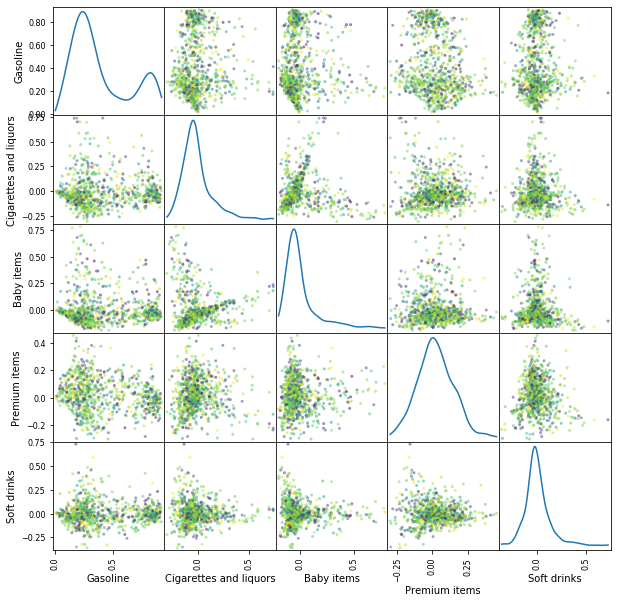

In [28]:
categorical = le.fit_transform(whole_df["income_desc"])
axes = pd.plotting.scatter_matrix(red_df, figsize=(10, 10),c=categorical, cmap='viridis', diagonal= 'kde')
new_labels=["{0:.2f}".format(float(i.get_text())) for i in axes[0,0].get_yticklabels()]
axes[0,0].set_yticklabels(new_labels)

plt.savefig("scatter_matrix_kmeans_labels")
plt.show()

# Conclusion
Unfortunately we were not able to able to find meaningful correlations for these groups and the demographic parameters
So we decided not t include these plots in out analysis